In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plot

### Load election results

In [2]:
all_results = pd.DataFrame()

for file in glob.glob('dos-export/*.csv'):
    file_results = pd.read_csv(file)
    file_results['Votes'] = file_results['Votes'].str.replace(',', '')
    file_results['Votes'] = pd.to_numeric(file_results['Votes'])

    all_results = pd.concat([all_results, file_results])

### Load list of counties with ACP type

In [3]:
counties = pd.read_csv('counties.csv')
county_results = pd.DataFrame(columns=['name', 'acp_type', 'election_year', 'dem_votes', 'oth_votes', 'rep_votes'])

### Merge election results with counties

In [4]:
for election in all_results['Election Name'].unique():
    for county in counties.name.unique():
        county_election_results = all_results[
            (all_results['Election Name'] == election) &
            (all_results['County Name'] == county)
        ]

        dem = county_election_results[county_election_results['Party Name'].str.startswith('Democrat')].Votes
        oth = county_election_results[
            ~(county_election_results['Party Name'].str.startswith('Democrat')) &
            ~(county_election_results['Party Name'].str.startswith('Republican'))
        ].Votes
        rep = county_election_results[county_election_results['Party Name'].str.startswith('Republican')].Votes

        county_results.loc[len(county_results.index)] = [
            county,
            counties[counties['name'] == county].type_name.values[0],
            election[0:4],
            dem.sum(), oth.sum(), rep.sum()
        ]

In [5]:
county_results.head(1)

,name,acp_type,election_year,dem_votes,oth_votes,rep_votes
0,ADAMS,Rural Middle America,2000,11682,903,20848


In [6]:
county_results.to_csv('county_results.csv')

### Sum by ACP county type, add Dem % of all votes

In [7]:
acp_type_results = county_results.groupby(['election_year', 'acp_type']).agg({
    'dem_votes': 'sum',
    'rep_votes': 'sum',
    'oth_votes': 'sum'
})

acp_type_results['dem_pct_all'] = acp_type_results.dem_votes / (
    acp_type_results.dem_votes + acp_type_results.rep_votes + acp_type_results.oth_votes
)

In [8]:
acp_type_results.head(1)

,,dem_votes,rep_votes,oth_votes,dem_pct_all
election_year,acp_type,,,,
2000,Big Cities,449182,100959,11039,0.800424


### Graphic showing changes in Dem %

In [9]:
pivot = acp_type_results.pivot_table(columns='acp_type', index='election_year', values='dem_pct_all')
pivot.to_csv('acp_type_results_dem_pct_all.csv')

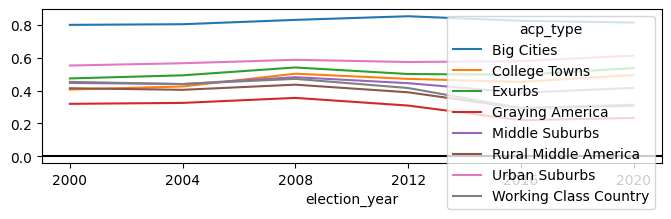

In [10]:
pivot.plot.line(figsize=(8, 2))
plot.axhline(0, c='k')

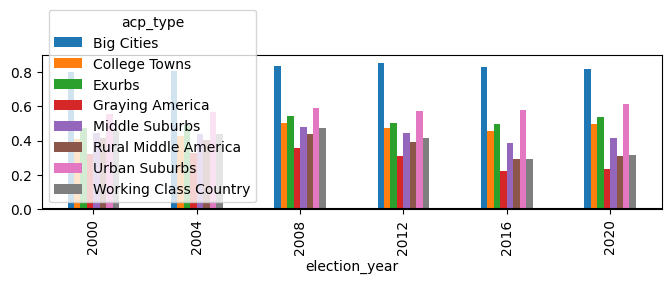

In [11]:
pivot.plot.bar(figsize=(8, 2))
plot.axhline(0, c='k')